# Create Time Series of Temperature and Electricity Demand for a Given Event


In [1]:
# Start by importing the packages we need:
import os
import datetime

import pandas as pd
import matplotlib.pyplot as plt

from datetime import timedelta


## Set the Directory Structure

In [2]:
# Identify the data input and output directories:
metadata_input_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2026_tbd/data/'
hw_cs_data_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2026_tbd/data/thermal_events_data/'
temp_data_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2026_tbd/data/temperature_data/'
load_data_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2026_tbd/data/load_data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2026_tbd/figures/case_study_results/'


## Write a Function to Process the Temperature Time Series Data


In [3]:
# Define a function to process the time series of temperature for a given NERC TPL-08 region:
def process_temperature_time_series(temp_data_dir: str, region: str):
    
    # Read in the raw time series data for all NERC regions:
    temp_df = pd.read_csv((temp_data_dir + 'NERC_Region_Daily_Temperature_1980_to_2024.csv'))
    
    # Subset to just the data for NERC region you want to use:
    subset_df = temp_df[(temp_df['Region'] == region)].copy()

    ## Set 'Date' to a datetime variable:
    subset_df['Date'] = pd.to_datetime(subset_df['Date'])
    
    # Add the day of year to be used as an averaging parameter:
    subset_df['DoY'] = subset_df['Date'].dt.dayofyear

    # Calculate the mean T_Min and T_Max by day of year:
    subset_df['T_Min_Mean'] = subset_df.groupby('DoY')['T_Min'].transform('mean').round(2)
    subset_df['T_Max_Mean'] = subset_df.groupby('DoY')['T_Max'].transform('mean').round(2)

    # Calculate the temperature anomalies:
    subset_df['T_Min_Delta'] = subset_df['T_Min'] - subset_df['T_Min_Mean']
    subset_df['T_Max_Delta'] = subset_df['T_Max'] - subset_df['T_Max_Mean']
    
    # Only keep the columns we need:
    output_df = subset_df[['Date','T_Min','T_Min_Mean','T_Min_Delta','T_Max','T_Max_Mean','T_Max_Delta']].copy()
    
    return output_df


In [4]:
# Test the function:
temp_df = process_temperature_time_series(temp_data_dir = temp_data_dir, 
                                          region = 'CA')

temp_df


,Date,T_Min,T_Min_Mean,T_Min_Delta,T_Max,T_Max_Mean,T_Max_Delta
0,1980-01-01,47.43,40.73,6.70,56.80,54.30,2.50
1,1980-01-02,41.88,41.59,0.29,57.35,54.62,2.73
2,1980-01-03,43.34,41.77,1.57,56.84,54.73,2.11
3,1980-01-04,42.60,41.91,0.69,55.79,54.62,1.17
4,1980-01-05,43.85,42.22,1.63,55.37,54.97,0.40
...,...,...,...,...,...,...,...
16432,2024-12-27,46.73,40.53,6.20,55.58,53.38,2.20
16433,2024-12-28,47.35,40.89,6.46,59.67,53.21,6.46
16434,2024-12-29,47.04,41.38,5.66,58.75,53.78,4.97
16435,2024-12-30,41.68,41.10,0.58,57.36,54.05,3.31


## Write a Function to Process the Load Time Series Data


In [5]:
def process_load_time_series(load_data_dir: str, region: str):

    # Read in the load data and subset to a given year:
    load_df = pd.read_csv((load_data_dir + 'WECC_Hourly_Loads_1980_to_2025.csv'))
       
    # Only keep the columns we need:
    subset_df = load_df[['Time_UTC', 'WECC_Load_MWh', (region + '_Load_MWh')]].copy()
    subset_df.rename(columns={'WECC_Load_MWh': 'Interconnection_Load', (region + '_Load_MWh'): 'Region_Load'}, inplace=True)
   
    # Set 'Time_UTC' to a datetime variable:
    subset_df['Time_UTC'] = pd.to_datetime(subset_df['Time_UTC'])

    # Add the hour of year to be used as an averaging parameter:
    subset_df['HoY'] = (((subset_df['Time_UTC'].dt.dayofyear -1) * 24) + subset_df['Time_UTC'].dt.hour)
    
    # Calculate the mean load by hour of year:
    subset_df['Interconnection_Load_Mean'] = subset_df.groupby('HoY')['Interconnection_Load'].transform('mean').round(2)
    subset_df['Region_Load_Mean'] = subset_df.groupby('HoY')['Region_Load'].transform('mean').round(2)

    # Calculate the load anomalies:
    subset_df['Interconnection_Load_Delta'] = subset_df['Interconnection_Load'] - subset_df['Interconnection_Load_Mean']
    subset_df['Region_Load_Delta'] = subset_df['Region_Load'] - subset_df['Region_Load_Mean']

    # Only keep the columns we need:
    output_df = subset_df[['Time_UTC','Interconnection_Load','Interconnection_Load_Mean','Interconnection_Load_Delta','Region_Load','Region_Load_Mean','Region_Load_Delta']].copy()
    
    return output_df
    

In [6]:
# Test the function:
load_df = process_load_time_series(load_data_dir = load_data_dir, 
                                   region = 'CA')

load_df


,Time_UTC,Interconnection_Load,Interconnection_Load_Mean,Interconnection_Load_Delta,Region_Load,Region_Load_Mean,Region_Load_Delta
0,1980-01-01 00:00:00,95949.05,96181.19,-232.14,34056.59,32076.15,1980.44
1,1980-01-01 01:00:00,100408.36,101770.50,-1362.14,35669.03,34548.81,1120.22
2,1980-01-01 02:00:00,102709.84,104813.27,-2103.43,36599.53,35912.07,687.46
3,1980-01-01 03:00:00,104593.05,106864.34,-2271.29,37876.25,37291.22,585.03
4,1980-01-01 04:00:00,104588.55,106979.44,-2390.89,38507.77,38252.27,255.50
...,...,...,...,...,...,...,...
395275,2024-12-31 19:00:00,97933.90,98306.31,-372.41,33235.87,32963.92,271.95
395276,2024-12-31 20:00:00,97279.37,97801.60,-522.23,33197.71,32993.46,204.25
395277,2024-12-31 21:00:00,97107.29,97550.03,-442.74,33381.65,33155.17,226.48
395278,2024-12-31 22:00:00,NaN,97643.19,NaN,NaN,33408.53,NaN


## Read in the Heat Wave or Cold Snap Library


In [7]:
# Extract the heat wave or cold snap library data for a given NERC region:
hw_cs_df = pd.read_csv((hw_cs_data_dir + 'hw_library_expanded.csv'))

hw_cs_df


,UID,NERC,Region,Start,End,Center,Center_DOY,T_Max_Min,Duration,Regions_Impacted,WECC_Load_Peak_MWh,WECC_Net_Load_Peak_MWh,Unnamed: 12,Region_Load_Peak_MWh,Region_Net_Load_Peak_MWh
0,HW_NERC1_Event32,1,CA,6/25/93,6/25/93,6/25/93,176,90.77,1,2,137293.0,135311.0,1982,57912.0,57452.0
1,HW_NERC1_Event34,1,CA,6/28/94,6/28/94,6/28/94,179,90.36,1,5,151484.0,148537.0,2947,59358.0,57469.0
2,HW_NERC1_Event104,1,CA,7/2/23,7/2/23,7/2/23,183,90.22,1,3,145102.0,NaN,145102,58313.0,NaN
3,HW_NERC1_Event72,1,CA,7/11/12,7/11/12,7/11/12,193,90.48,1,5,153630.0,150361.0,3269,61016.0,59256.0
4,HW_NERC1_Event92,1,CA,7/12/20,7/12/20,7/12/20,194,90.50,1,7,151843.0,148417.0,3426,59410.0,57525.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,HW_NERC16_Event47,16,SW,7/11/05,7/21/05,7/16/05,197,101.87,11,7,161198.0,158391.0,2807,35203.0,35028.0
1724,HW_NERC16_Event98,16,SW,7/3/24,7/14/24,7/8/24,190,101.40,12,8,162028.0,NaN,162028,33055.0,NaN
1725,HW_NERC16_Event35,16,SW,7/18/00,7/29/00,7/23/00,205,100.71,12,3,149420.0,146168.0,3252,32834.0,32686.0
1726,HW_NERC16_Event84,16,SW,8/9/20,8/20/20,8/14/20,227,100.75,12,3,166405.0,162061.0,4344,32341.0,31655.0


## Make the Plot


In [8]:
def plot_event_time_series(event: str, window: int, hw_cs_data_dir: str, temp_data_dir: str, load_data_dir: str, metadata_input_dir: str,
                           image_output_dir: str, image_resolution: int, save_images=False):

    # Read in the heat wave event library:
    hw_cs_df = pd.read_csv((hw_cs_data_dir + 'hw_library_expanded.csv'))
    
    # Subset to just the event specified:
    hw_cs_df = hw_cs_df.loc[hw_cs_df['UID'] == event].copy()

    # Extract the event parameters used to query the functions defined above:
    region = hw_cs_df.loc[hw_cs_df['UID'] == event, 'Region'].item()
    start_date = pd.to_datetime(hw_cs_df.loc[hw_cs_df['UID'] == event, 'Start'].item()) - pd.Timedelta(1, "d")
    end_date = pd.to_datetime(hw_cs_df.loc[hw_cs_df['UID'] == event, 'End'].item()) + pd.Timedelta(1, "d")
    
    # Read in NERC region name file and extract the name:
    nerc = pd.read_csv((metadata_input_dir + 'nerc_tpl08_region_names.csv'))
    nerc_name = nerc.loc[nerc['short_name'] == region, 'long_name'].item()
        
    # Process the temperature time series and subset the data to just dates within the time window:
    temp_df = process_temperature_time_series(temp_data_dir = temp_data_dir, region = region)
    temp_df['Date'] = pd.to_datetime(temp_df['Date'])
    temp_subset_df = temp_df[(temp_df['Date'] >= pd.to_datetime((start_date - pd.Timedelta(days=window)))) & (temp_df['Date'] <= pd.to_datetime((end_date + pd.Timedelta(days=window))))].copy()
    peak_temp_subset_df = temp_df[(temp_df['Date'] >= pd.to_datetime((start_date))) & (temp_df['Date'] <= pd.to_datetime((end_date)))].copy()

    # Process the load time series and subset the data to just dates within the time window:
    load_df = process_load_time_series(load_data_dir = load_data_dir, region = region)
    load_df['Time_UTC'] = pd.to_datetime(load_df['Time_UTC'])
    load_subset_df = load_df[(load_df['Time_UTC'] >= pd.to_datetime(start_date - pd.Timedelta(days=window))) & (load_df['Time_UTC'] <= pd.to_datetime(end_date + pd.Timedelta(days=window)))].copy()
    peak_load_subset_df = load_df[(load_df['Time_UTC'] >= pd.to_datetime(start_date)) & (load_df['Time_UTC'] <= pd.to_datetime(end_date))].copy()

    # Calculate the minimum and maximum values to be used in plotting:
    temp_min = min([temp_subset_df['T_Max'].min(),temp_subset_df['T_Max_Mean'].min()]) - 3
    temp_max = max([temp_subset_df['T_Max'].max(),temp_subset_df['T_Max_Mean'].max()]) + 3
    region_load_min = min([load_subset_df['Region_Load'].min(),load_subset_df['Region_Load_Mean'].min()]) * 0.9
    region_load_max = max([load_subset_df['Region_Load'].max(),load_subset_df['Region_Load_Mean'].max()]) * 1.1
    wecc_load_min = min([load_subset_df['Interconnection_Load'].min(),load_subset_df['Interconnection_Load_Mean'].min()]) * 0.9
    wecc_load_max = max([load_subset_df['Interconnection_Load'].max(),load_subset_df['Interconnection_Load_Mean'].max()]) * 1.1
    
    # Calculate the temperature and load anomalies:
    temp_peak = peak_temp_subset_df['T_Max'].max().round(1)
    temp_anom = peak_temp_subset_df.loc[peak_temp_subset_df['T_Max'].idxmax(), ['T_Max_Delta']].item().round(1)
    region_load_peak = peak_load_subset_df['Region_Load'].max().round(0)
    region_load_anom = peak_load_subset_df.loc[peak_load_subset_df['Region_Load'].idxmax(), ['Region_Load_Delta']].item().round(0)
    wecc_load_peak = peak_load_subset_df['Interconnection_Load'].max().round(0)
    wecc_load_anom = peak_load_subset_df.loc[peak_load_subset_df['Interconnection_Load'].idxmax(), ['Interconnection_Load_Delta']].item().round(0)

    # Adjust the start and end dates by 12 hours if they're the same:
    if start_date == end_date:
       event_start_date = start_date - pd.Timedelta(0.5, "d")
       event_end_date = end_date + pd.Timedelta(0.5, "d")
    else:
       event_start_date = start_date
       event_end_date = end_date

    # Make the plot:
    plt.figure(figsize=(25,30))
    plt.rcParams['font.size'] = 18
    plt.rcParams['axes.axisbelow'] = True
    
    ax1 = plt.subplot(311)
    plt.plot(temp_subset_df['Date'], temp_subset_df['T_Max'], color='r', linestyle='-', linewidth=3)
    plt.plot(temp_subset_df['Date'], temp_subset_df['T_Max_Mean'], color='k', linestyle='--', linewidth=2)
    plt.fill_between([pd.to_datetime(event_start_date), pd.to_datetime(event_end_date)], temp_min, temp_max, color='r', alpha=0.15)
    plt.text(0.8, 0.925, ('Hottest Temperature = ' + str(temp_peak) + '$^\circ$F'), fontsize=21, horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
    plt.text(0.8, 0.825, ('Temperature Anomaly = ' + str(temp_anom) + '$^\circ$F'), fontsize=21, horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
    plt.xlim([pd.to_datetime(start_date - pd.Timedelta(days=window)), pd.to_datetime(end_date + pd.Timedelta(days=window))])
    plt.ylim([temp_min, temp_max])
    plt.ylabel('Max Temp. [$^\circ$F]', fontsize=18)
    plt.title(('Daily Maximum Temperature in ' + nerc_name))

    ax2 = plt.subplot(312)
    plt.plot(load_subset_df['Time_UTC'], load_subset_df['Region_Load'], color='m', linestyle='-', linewidth=3)
    plt.plot(load_subset_df['Time_UTC'], load_subset_df['Region_Load_Mean'], color='k', linestyle='--', linewidth=2)
    plt.fill_between([pd.to_datetime(event_start_date), pd.to_datetime(event_end_date)], region_load_min, region_load_max, color='r', alpha=0.15)
    plt.text(0.8, 0.925, ('Peak Demand = ' + str(region_load_peak) + ' MWh'), fontsize=21, horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
    plt.text(0.8, 0.825, ('Peak Demand Anomaly = ' + str(region_load_anom) + ' MWh'), fontsize=21, horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
    plt.xlim([pd.to_datetime(start_date - pd.Timedelta(days=window)), pd.to_datetime(end_date + pd.Timedelta(days=window))])
    plt.ylim([region_load_min, region_load_max])
    plt.ylabel('Regional Demand [MWh]', fontsize=18)
    plt.title(('Hourly Electricity Demand in ' + nerc_name))

    ax3 = plt.subplot(313)
    plt.plot(load_subset_df['Time_UTC'], load_subset_df['Interconnection_Load'], color='m', linestyle='-', linewidth=3)
    plt.plot(load_subset_df['Time_UTC'], load_subset_df['Interconnection_Load_Mean'], color='k', linestyle='--', linewidth=2)
    plt.fill_between([pd.to_datetime(event_start_date), pd.to_datetime(event_end_date)], wecc_load_min, wecc_load_max, color='r', alpha=0.15)
    plt.text(0.8, 0.925, ('Peak Demand = ' + str(wecc_load_peak) + ' MWh'), fontsize=21, horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)
    plt.text(0.8, 0.825, ('Peak Demand Anomaly = ' + str(wecc_load_anom) + ' MWh'), fontsize=21, horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)
    plt.xlim([pd.to_datetime(start_date - pd.Timedelta(days=window)), pd.to_datetime(end_date + pd.Timedelta(days=window))])
    plt.ylim([wecc_load_min, wecc_load_max])
    plt.ylabel('Interconnection Demand [MWh]', fontsize=18)
    plt.title(('Hourly Electricity Demand in the Western Interconnection'))
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       if event == 'HW_NERC4_Event2':
          filename = (os.path.join(image_output_dir + 'ED1-GB_Time_Series.png'))
       if event == 'HW_NERC4_Event9':
          filename = (os.path.join(image_output_dir + 'ED2-GB_Time_Series.png'))
       if event == 'HW_NERC1_Event79':
          filename = (os.path.join(image_output_dir + 'HC1-CA_Time_Series.png'))
       if event == 'HW_NERC1_Event8':
          filename = (os.path.join(image_output_dir + 'HC2-CA_Time_Series.png'))  
       if event == 'HW_NERC11_Event62':
          filename = (os.path.join(image_output_dir + 'SE1-PNW_Time_Series.png'))
       if event == 'HW_NERC11_Event88':
          filename = (os.path.join(image_output_dir + 'SE2-PNW_Time_Series.png'))
       plt.savefig(filename, dpi=image_resolution, bbox_inches='tight')
       #plt.close()

    return load_subset_df


,Time_UTC,Interconnection_Load,Interconnection_Load_Mean,Interconnection_Load_Delta,Region_Load,Region_Load_Mean,Region_Load_Delta
321096,2016-07-22 00:00:00,148866.84,140907.05,7959.79,24820.13,23956.01,864.12
321097,2016-07-22 01:00:00,149627.77,141773.06,7854.71,24899.44,24182.63,716.81
321098,2016-07-22 02:00:00,147428.01,140171.33,7256.68,24495.52,24015.33,480.19
321099,2016-07-22 03:00:00,142800.26,136797.82,6002.44,23793.36,23548.34,245.02
321100,2016-07-22 04:00:00,137194.00,131319.03,5874.97,22993.05,22827.36,165.69
...,...,...,...,...,...,...,...
321404,2016-08-03 20:00:00,127852.38,126014.01,1838.37,22173.32,22468.77,-295.45
321405,2016-08-03 21:00:00,132122.61,130326.04,1796.57,22568.55,22802.15,-233.60
321406,2016-08-03 22:00:00,136018.66,133965.06,2053.60,22909.41,23008.23,-98.82
321407,2016-08-03 23:00:00,137821.29,135976.42,1844.87,22954.85,22932.10,22.75


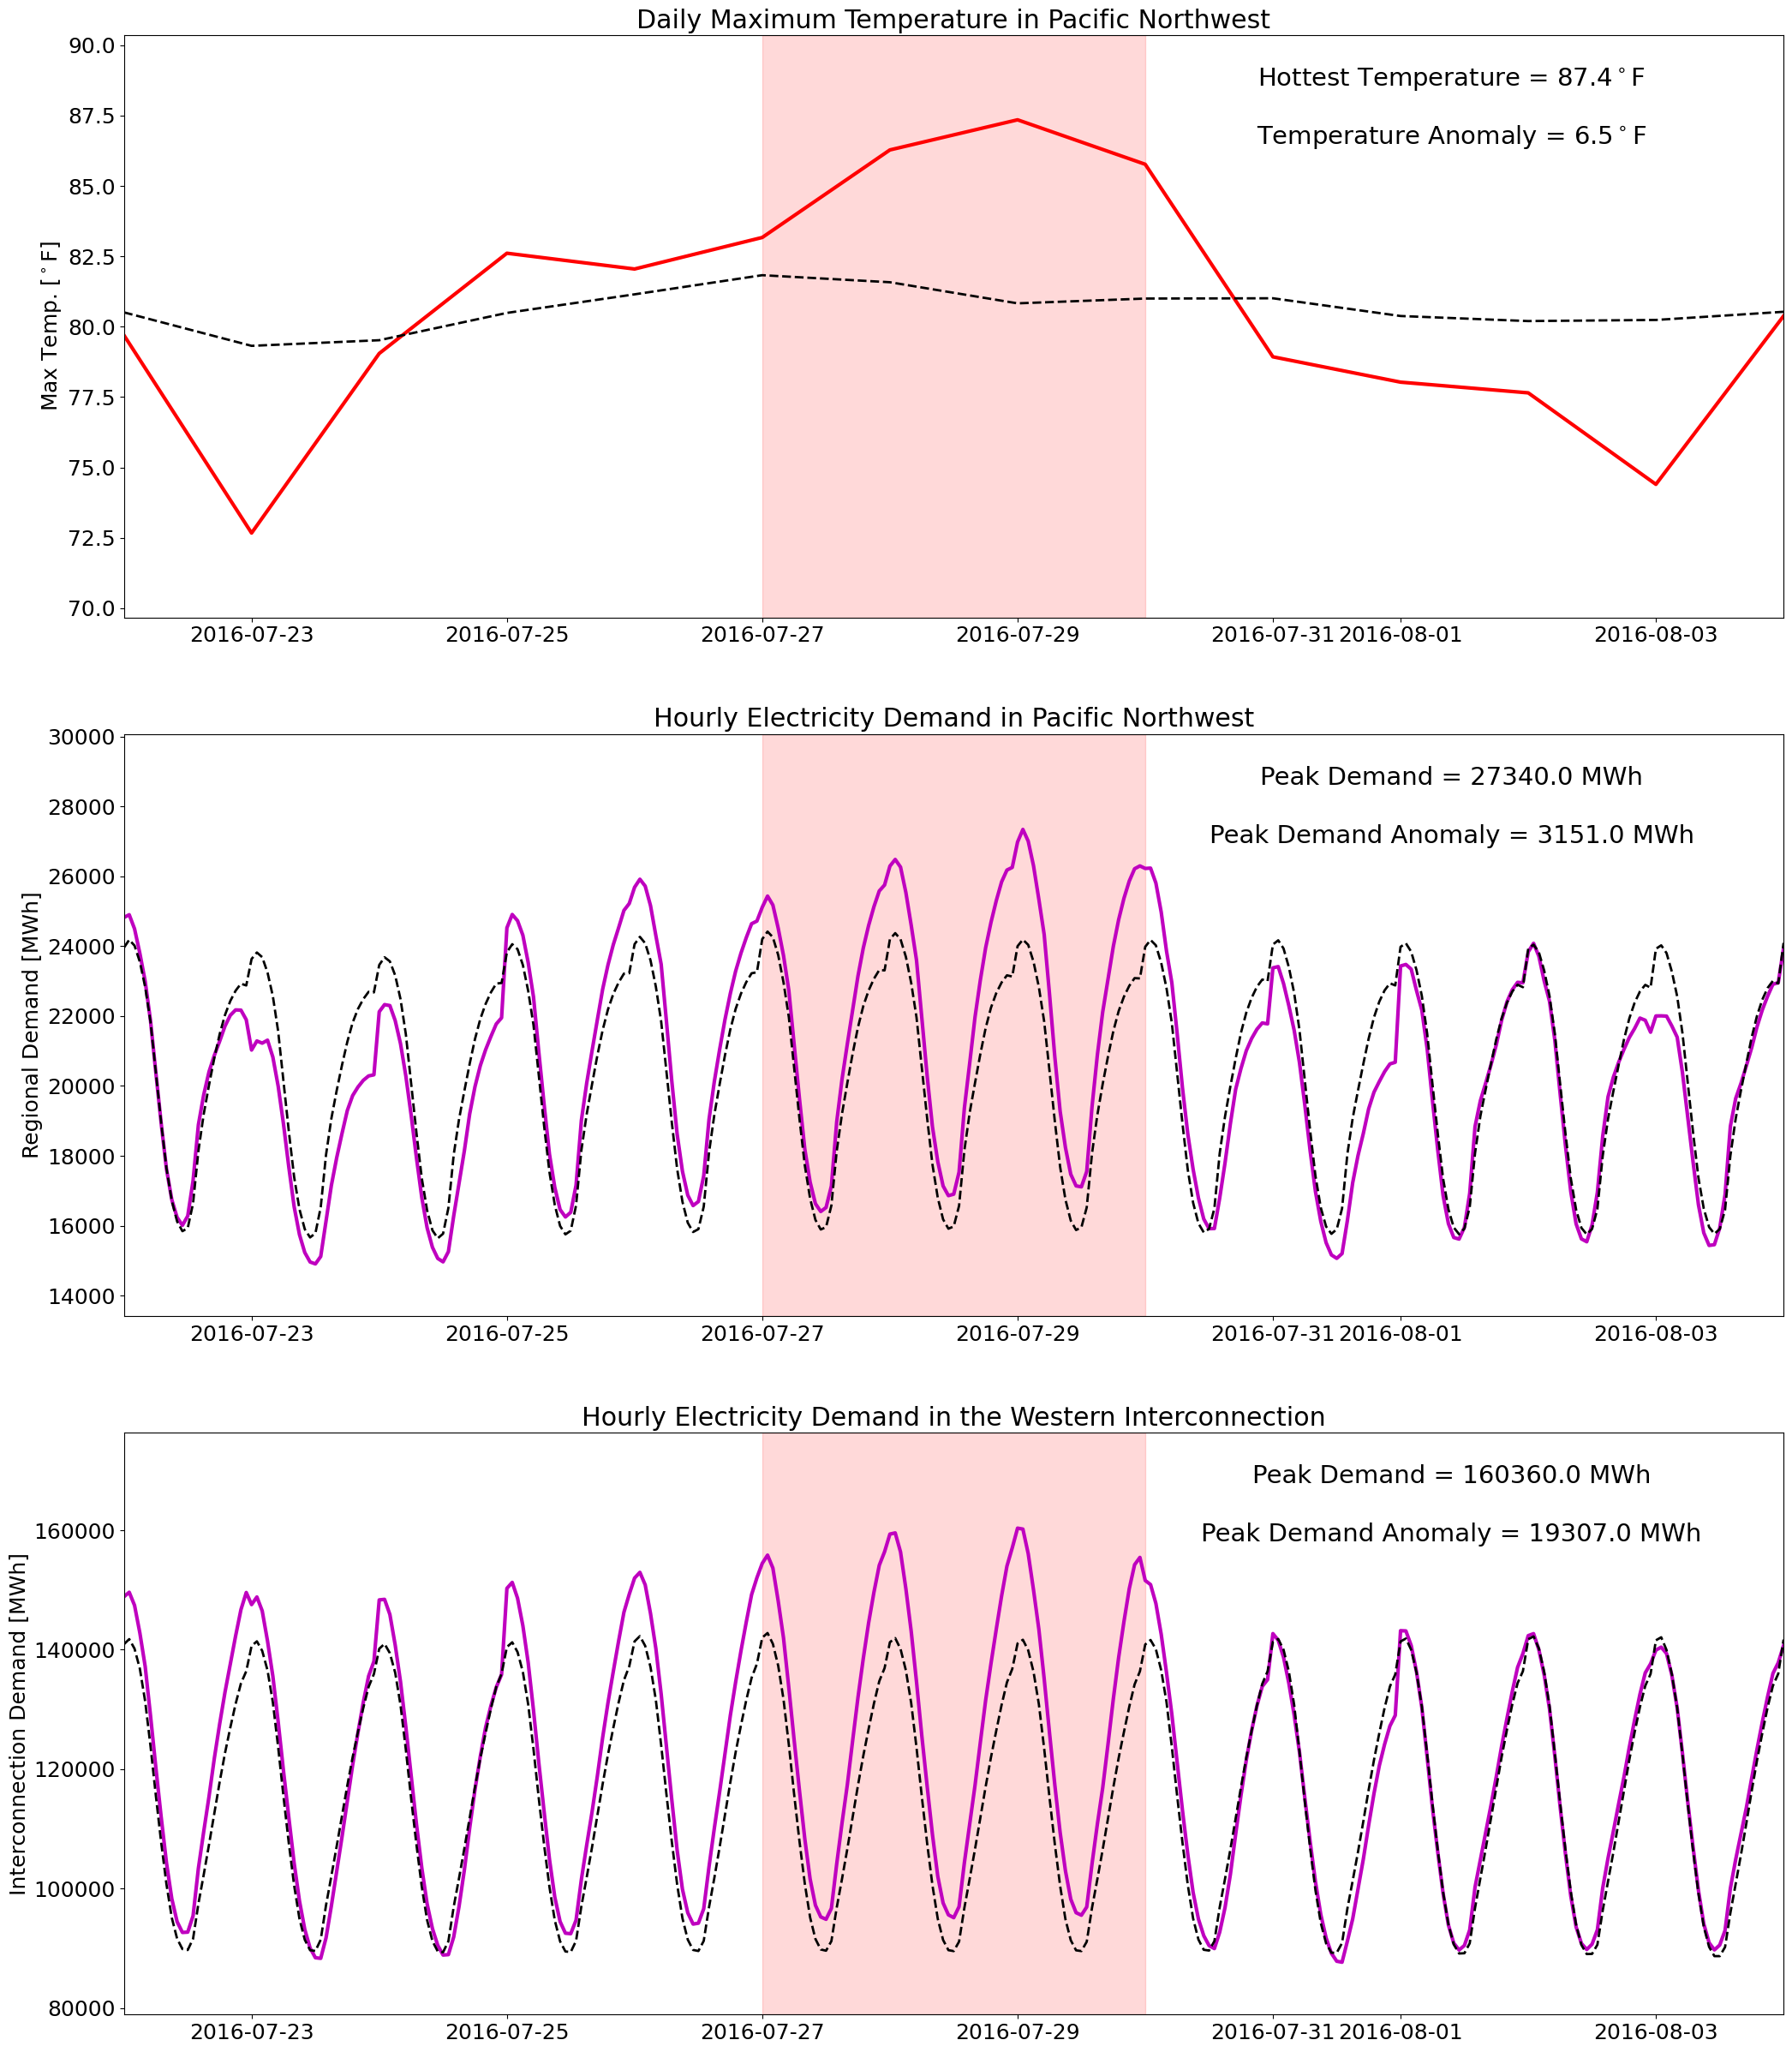

In [14]:
# Test the function:
output_df = plot_event_time_series(event = 'HW_NERC11_Event88',
                                   window = 5, # Days before and after the start of the event to make the plot
                                   hw_cs_data_dir = hw_cs_data_dir,
                                   temp_data_dir = temp_data_dir, 
                                   load_data_dir = load_data_dir,
                                   metadata_input_dir = metadata_input_dir,
                                   image_output_dir = image_output_dir, 
                                   image_resolution = 150, 
                                   save_images = True)

output_df
